In [126]:
import json
import requests
from dateutil.relativedelta import relativedelta
import csv
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [127]:
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_modern = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
headers = {
    'User-Agent': 'https://github.com/AaronJacobson',
    'From': 'aaronlj@uw.edu'
}


output_folder_prefix = "C:\\Users\\AaronJacobsonDesk3\\Documents\\UWMSDS\\Classes\\Fall2021\\DATA512\\DATA512\\DATA512\\"

legacy_desktop_filepath = output_folder_prefix + "legacy_desktop-site_2007123100-2016070100.json"
legacy_mobile_filepath = output_folder_prefix + "legacy_mobile-site_2007123100-2016070100.json"
modern_desktop_filepath = output_folder_prefix + "pageviews_desktop_2015070100-2021091000.json"
modern_mobileapp_filepath = output_folder_prefix + "pageviews_mobile-app_2015070100-2021091000.json"
modern_mobileweb_filepath = output_folder_prefix + "pageviews_mobile-web_2015070100-2021091000.json"

legacy_access_types = ['desktop-site', 'mobile-site']
modern_access_types = ['desktop', 'mobile-app', 'mobile-web']

data_output_filepath = output_folder_prefix + "en-wikipedia_traffic_200712-202108.csv"
plot_output_filepath = output_folder_prefix + "hcds-a1-plot.png"

In [128]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

def get_monthly_legacy(query_type):
    params_legacy = {
        "project" : "en.wikipedia.org",
        "access-site" : query_type,
        "granularity" : "monthly",
        "start" : "2007123100",
        "end" : "2016070100"
    }
    return api_call(endpoint_legacy, params_legacy)   

def get_monthly_modern(query_type):
    params_modern = {
        "project" : "en.wikipedia.org",
        "access" : "desktop",
        "agent" : "user",
        "granularity" : "monthly",
        "start" : "2015070100",
        "end" : "2021101000"
    }
    return api_call(endpoint_modern, params_modern)

In [129]:
with open(legacy_desktop_filepath, 'w') as ldf:
    json.dump(get_monthly_legacy(legacy_access_types[0]), ldf)
with open(legacy_mobile_filepath, 'w') as lmf:
    json.dump(get_monthly_legacy(legacy_access_types[1]), lmf)
with open(modern_desktop_filepath, 'w') as mdf:
    json.dump(get_monthly_modern(modern_access_types[0]), mdf)
with open(modern_mobileapp_filepath, 'w') as mmaf:
    json.dump(get_monthly_modern(modern_access_types[1]), mmaf)
with open(modern_mobileweb_filepath, 'w') as mmwf:
    json.dump(get_monthly_modern(modern_access_types[2]), mmwf)

In [130]:
legacy_desktop_data = None
legacy_mobile_data = None
modern_desktop_data = None
modern_mobileapp_data = None
modern_mobileweb_data = None

with open(legacy_desktop_filepath) as f:
    legacy_desktop_data = json.load(f)
with open(legacy_mobile_filepath) as f:
    legacy_mobile_data = json.load(f)
with open(modern_desktop_filepath) as f:
    modern_desktop_data = json.load(f)
with open(modern_mobileapp_filepath) as f:
    modern_mobileapp_data = json.load(f)
with open(modern_mobileweb_filepath) as f:
    modern_mobileweb_data = json.load(f)

In [131]:
def timestamp_data(dict_to_format):
    output_dict = {}
    for entry in dict_to_format:
        output_dict[entry['timestamp']] = entry
    return output_dict

In [132]:
legacy_desktop_data = timestamp_data(legacy_desktop_data['items'])
legacy_mobile_data = timestamp_data(legacy_mobile_data['items'])
modern_desktop_data = timestamp_data(modern_desktop_data['items'])
modern_mobileapp_data = timestamp_data(modern_mobileapp_data['items'])
modern_mobileweb_data = timestamp_data(modern_mobileweb_data['items'])

In [133]:
data_date = datetime.datetime(year=2007, month=12, day=1)
end_date = datetime.datetime(year=2021, month=9, day=1)
month_increment = relativedelta(months=1)

In [134]:
csv_file_header = ['year',
                    'month',
                    'pagecount_all_views',
                    'pagecount_desktop_views',
                    'pagecount_mobile_views',
                    'pageview_all_views',
                    'pageview_desktop_views',
                    'pageview_mobile_views']
with open(data_output_filepath, 'w', newline='') as data_out:
    writer = csv.writer(data_out, delimiter=',')
    writer.writerow(csv_file_header)
    
    while data_date != end_date:
        string_date = data_date.strftime("%Y%m%d%H")
        pagecount_desktop = 0
        pagecount_mobile = 0
        pagecount_total = 0
        pageview_desktop = 0
        pageview_mobileapp = 0
        pageview_mobileweb = 0
        pageview_mobile = 0
        pageview_total = 0

        if string_date in legacy_desktop_data:
            pagecount_desktop = legacy_desktop_data[string_date]['count']
        if string_date in legacy_mobile_data:
            pagecount_mobile = legacy_mobile_data[string_date]['count']
        pagecount_total = pagecount_desktop + pagecount_mobile

        if string_date in modern_desktop_data:
            pageview_desktop = modern_desktop_data[string_date]['views']
        if string_date in modern_mobileapp_data:
            pageview_mobileapp = modern_mobileapp_data[string_date]['views']
        if string_date in modern_mobileweb_data:
            pageview_mobileweb = modern_mobileweb_data[string_date]['views']
        pageview_mobile = pageview_mobileapp + pageview_mobileweb

        pageview_total = pageview_desktop + pageview_mobile

        writer.writerow([
            data_date.year,
            data_date.month,
            pagecount_total,
            pagecount_desktop,
            pagecount_mobile,
            pageview_total,
            pageview_desktop,
            pageview_mobile]
        )
        data_date = data_date + month_increment


In [135]:
data = pd.read_csv(data_output_filepath)

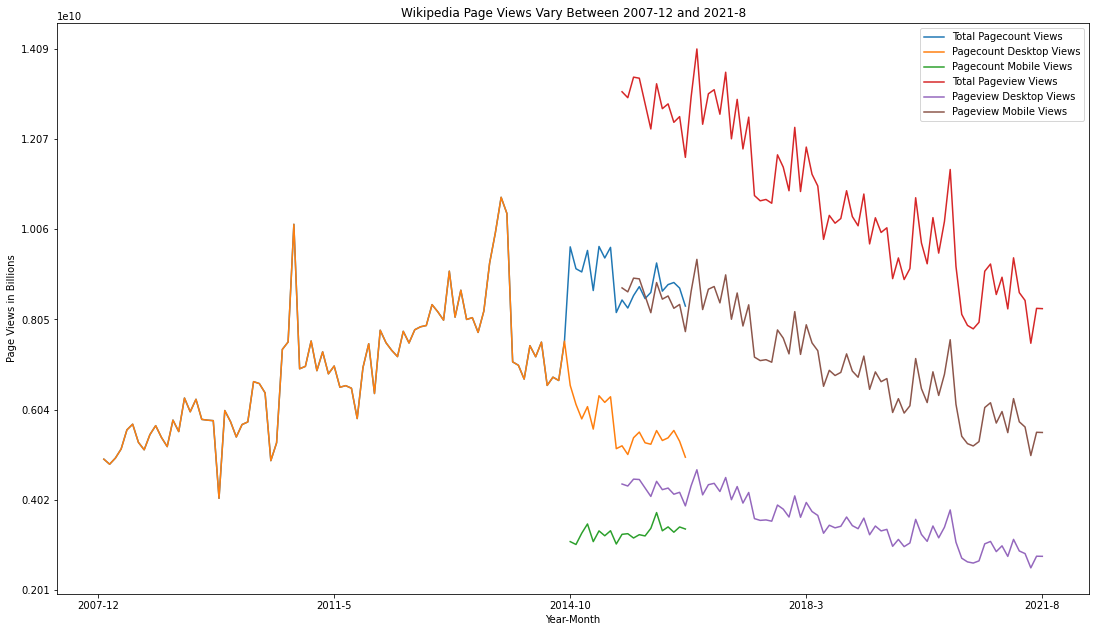

In [136]:
plt.plot(data.index.values.tolist(), data['pagecount_all_views'].replace(0, np.nan, inplace=False))
plt.plot(data.index.values.tolist(), data['pagecount_desktop_views'].replace(0, np.nan, inplace=False))
plt.plot(data.index.values.tolist(), data['pagecount_mobile_views'].replace(0, np.nan, inplace=False))
plt.plot(data.index.values.tolist(), data['pageview_all_views'].replace(0, np.nan, inplace=False))
plt.plot(data.index.values.tolist(), data['pageview_desktop_views'].replace(0, np.nan, inplace=False))
plt.plot(data.index.values.tolist(), data['pageview_mobile_views'].replace(0, np.nan, inplace=False))
plt.xlabel('Year-Month')
plt.ylabel('Page Views in Billions')
plt.title('Wikipedia Page Views Vary Between 2007-12 and 2021-8')
year_month = (data['year'].astype(str) + "-" + data['month'].astype(str)).tolist()
plt.xticks(data.index.values.tolist()[::41], year_month[::41])
y_ticks = list(range(1,8))
y_ticks = np.asarray(y_ticks) * (data.max().max() / 7.0)
plt.yticks(y_ticks)
plt.legend(['Total Pagecount Views',
            'Pagecount Desktop Views', 
            'Pagecount Mobile Views', 
            'Total Pageview Views', 
            'Pageview Desktop Views',
            'Pageview Mobile Views'])
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(18.5, 10.5)
plt.savefig(plot_output_filepath)